In [1]:
from models import SequenceDNN_Regression, Basset

from sklearn.model_selection import train_test_split

from collections import OrderedDict
from pprint import pprint
from warnings import warn

import numpy as np
import matplotlib.pyplot as plt

import math

%matplotlib inline

Using Theano backend.
Using gpu device 0: Tesla K80 (CNMeM is disabled, cuDNN 5005)
/usr/local/anaconda3/envs/regression_dragonn_new/lib/python2.7/site-packages/theano/tensor/signal/downsample.py:6: UserWarning: downsample module has been moved to the theano.tensor.signal.pool module.
  "downsample module has been moved to the theano.tensor.signal.pool module.")


In [2]:
data_dir = 'data/'
model_dir = 'models/'
rebuild_data = True

if rebuild_data:
    
    key_to_seq = OrderedDict()
    seq_len = 145
    reg_len = 295
    skip_len = 5

    with open("../../data/Scaleup_counts_sequences/ScaleUpDesign1.sequences.txt") as f:
        for line in f:
            key, seq = line.strip().split()

            # TODO: Figure out if this is an OK thing to do. 'N' basically means the 
            # sequencing software couldn't figure out what the base was...?
            if "N" in seq:
                seq = seq.replace("N", "A")

            assert key not in key_to_seq
            key_to_seq[key] = seq

    with open("../../data/Scaleup_counts_sequences/ScaleUpDesign2.sequences.txt") as f:
        for line in f:
            key, seq = line.strip().split()

            if "N" in seq:
                seq = seq.replace("N", "A")

            assert key not in key_to_seq
            key_to_seq[key] = seq


In [3]:
if rebuild_data:
    split_data = {}
    data = {}
    sample_weights = {}
    cell_types =  ["HepG2", "K562"]
    promoters = ["SV40P", "minP"]
    design_names = ["ScaleUpDesign1", "ScaleUpDesign2"]

    for cell_type in cell_types:
        for promoter in promoters:
            experiment_key = (cell_type, promoter)
            data[experiment_key] = {}
            split_data[experiment_key] = {}
            sample_weights[experiment_key] = {}

            for design_name in design_names:

                with open("../../data/Scaleup_normalized/{}_{}_{}_mRNA_Rep1.normalized".format(cell_type, design_name, promoter)) as f:
                    for line in f:
                        parts = line.strip().split()

                        key = parts[0]
                        val = float(parts[1])
                        if parts[2] == "1":
                            data[experiment_key][key] = val
                            split_data[experiment_key][key] = (val, 0)

                with open("../../data/Scaleup_normalized/{}_{}_{}_mRNA_Rep2.normalized".format(cell_type, design_name, promoter)) as f:
                    for line in f:
                        parts = line.strip().split()

                        key = parts[0]
                        val = float(parts[1])
                        if parts[2] == "1" and key in data[experiment_key]:
                            
                            dot_prod = (val + data[experiment_key][key])
                            norm = math.sqrt(val**2 + data[experiment_key][key]**2)
                            cos = dot_prod/(math.sqrt(2) * norm)
                            sin = math.sqrt(1-cos**2)
                            w = sin * norm
#                             w = abs(cos)
                                    
                            sample_weights[experiment_key][key] = w
                            
                            data[experiment_key][key] = (val + data[experiment_key][key]) / 2.0
                            
                            split_data[experiment_key][key] = (split_data[experiment_key][key][0], val)

    # One hot encode DNA sequences the standard way.
    bases = ['A', 'T', 'C', 'G']

    def one_hot_encode_seq(seq):
        result = np.zeros((len(bases), len(seq)))

        for i, base in enumerate(seq):
            result[bases.index(base), i] = 1

        return result

    def one_hot_encode_reg(reg):
        result = np.zeros((len(bases), reg_len))

        key = reg[0]
        parts = key.split('_')
        tile_pos = int(parts[3])

        seq = reg[1]

        for i, base in enumerate(seq):
            result[bases.index(base), i + (tile_pos * skip_len)] = 1

        return result

    def seqs_to_encoded_matrix(seqs):
        # Wrangle the data into a shape that Dragonn wants.
        result = np.concatenate(
            map(one_hot_encode_seq, seqs)
        ).reshape(
            len(seqs), 1, len(bases), len(seqs[0])
        )

        # Check we actually did the encoding right.
        for i in range(len(seqs)):
            for j in range(len(seqs[0])):
                assert sum(result[i, 0, :, j]) == 1

        return result

    def regs_to_encoded_matrix(regs):
        # Wrangle the data into a shape that Dragonn wants.
        result = np.concatenate(
            map(one_hot_encode_reg, regs)
        ).reshape(
            len(regs), 1, len(bases), reg_len
        )

        return result

    valid_keys = list(reduce(
        lambda acc, d: acc.intersection(d.keys()), 
        data.values()[1:], 
        set(data.values()[0].keys())
    ))


In [6]:
if rebuild_data:

    X_t = seqs_to_encoded_matrix([key_to_seq[key] for key in valid_keys])
    X_r = regs_to_encoded_matrix([(key, key_to_seq[key]) for key in valid_keys])

    from sklearn.preprocessing import StandardScaler, MinMaxScaler

    scaler = MinMaxScaler(feature_range=(-1, 1))

    experiment_labels = []
    weights = []
    for experiment_key, key_to_normalized in data.items():

        filtered_normalized = np.array([key_to_normalized[key] for key in valid_keys]).reshape(-1, 1)
        filtered_weights = np.array([sample_weights[experiment_key][key] for key in valid_keys]).reshape(-1, 1)
        
        scaled = scaler.fit_transform(filtered_normalized)

        experiment_labels.append(scaled)
        weights.append(filtered_weights)

    print len(weights)
    y = np.hstack(experiment_labels)
    weights = np.hstack(weights).mean(axis=1) # What?
    print weights.shape
    
    scaler = MinMaxScaler(feature_range=(0,1))
    weights = scaler.fit_transform(-weights)
    print weights.shape
        
    tasks = data.keys()
    
    """
    np.save(data_dir + 'X_t.npy', X_t)
    np.save(data_dir + 'X_r.npy', X_r)
    np.save(data_dir + 'y.npy', y)
    np.save(data_dir + 'tasks.npy', tasks)
    np.save(data_dir + 'weights.npy', weights)
    """

else:
    
    X_t = np.load(data_dir + 'X_t.npy')
    X_r = np.load(data_dir + 'X_r.npy')
    y = np.load(data_dir + 'y.npy')
    tasks = np.load(data_dir + 'tasks.npy')
    weights = np.load(data_dir + 'weights.npy')

X = X_t

X_train, X_valid, y_train, y_valid, weights_train, weights_valid = train_test_split(
    X, y, weights, test_size=0.2, random_state=42
)

4
(277409, 4)
(277409, 4)


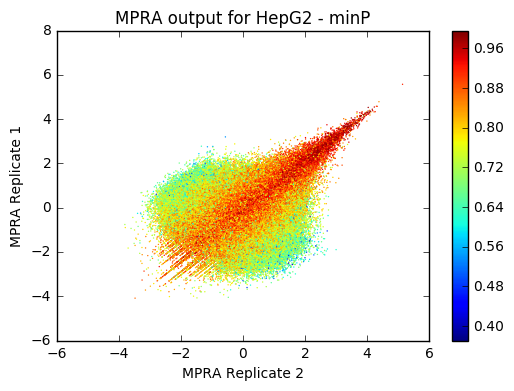

('HepG2', 'minP')
[[ 1.0000036   0.32542667]
 [ 0.32542667  1.0000036 ]]


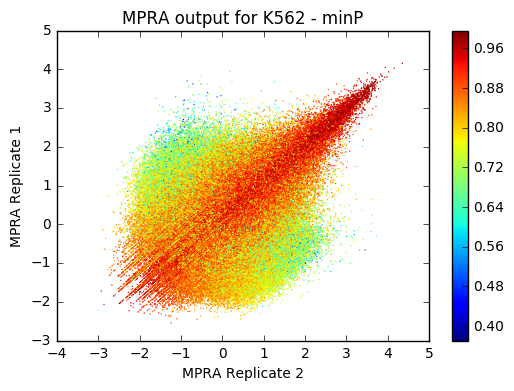

('K562', 'minP')
[[ 1.0000036   0.36576822]
 [ 0.36576822  1.0000036 ]]


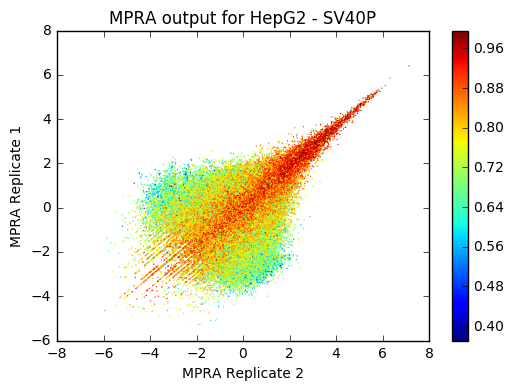

('HepG2', 'SV40P')
[[ 1.0000036   0.45198875]
 [ 0.45198875  1.0000036 ]]


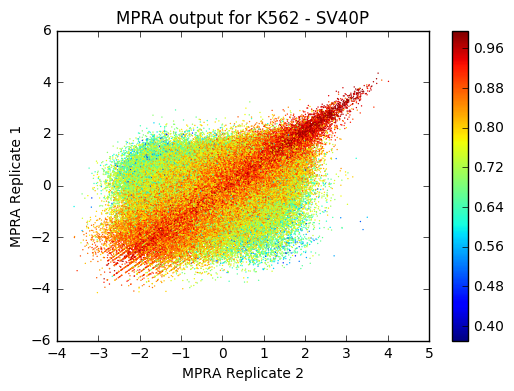

('K562', 'SV40P')
[[ 1.0000036   0.46768978]
 [ 0.46768978  1.0000036 ]]


In [22]:
from sklearn.preprocessing import scale
TASKS = ['HepG2 - minP', 'K562 - minP', 'HepG2 - SV40P', 'K562 - SV40P']
#  Variance between replicates
for i, (experiment_key, key_to_normalized) in enumerate(split_data.items()):
    vals = np.array([scale([key_to_normalized[key][0] for key in valid_keys]),
                     scale([key_to_normalized[key][1] for key in valid_keys])])

    sc = plt.scatter(vals[0, :], vals[1, :], c=weights.mean(axis = 1), lw = 0, s = 1)
    plt.colorbar(sc)
    plt.title("MPRA output for {}".format(TASKS[i]))
    plt.ylabel("MPRA Replicate 1")
    plt.xlabel("MPRA Replicate 2")
    plt.show()
    print experiment_key
    print np.cov(vals)

/usr/local/anaconda3/envs/regression_dragonn_new/lib/python2.7/site-packages/sklearn/preprocessing/data.py:321: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/usr/local/anaconda3/envs/regression_dragonn_new/lib/python2.7/site-packages/sklearn/preprocessing/data.py:356: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)


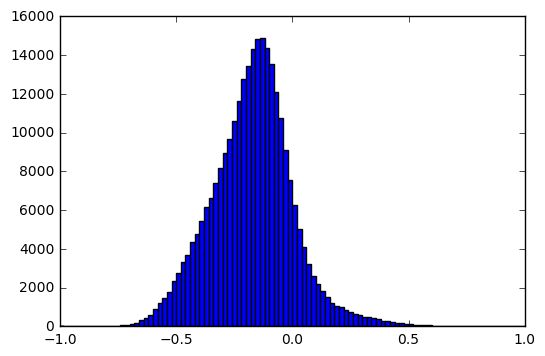

/usr/local/anaconda3/envs/regression_dragonn_new/lib/python2.7/site-packages/sklearn/preprocessing/data.py:321: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/usr/local/anaconda3/envs/regression_dragonn_new/lib/python2.7/site-packages/sklearn/preprocessing/data.py:356: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)


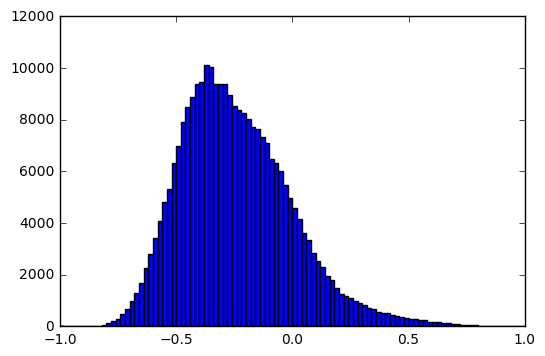

/usr/local/anaconda3/envs/regression_dragonn_new/lib/python2.7/site-packages/sklearn/preprocessing/data.py:321: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/usr/local/anaconda3/envs/regression_dragonn_new/lib/python2.7/site-packages/sklearn/preprocessing/data.py:356: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)


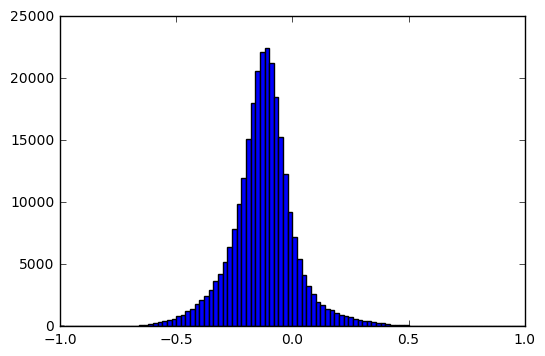

/usr/local/anaconda3/envs/regression_dragonn_new/lib/python2.7/site-packages/sklearn/preprocessing/data.py:321: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/usr/local/anaconda3/envs/regression_dragonn_new/lib/python2.7/site-packages/sklearn/preprocessing/data.py:356: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)


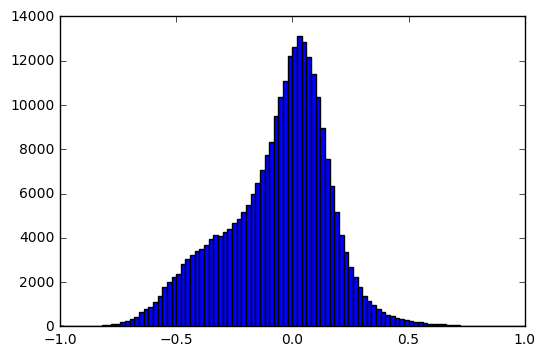

In [16]:
for i in range(4):
    plt.hist(MinMaxScaler((-1, 1)).fit_transform(y[:, i]), bins = 100)
    plt.show()

In [ ]:
model = Basset(145,
               pool_width=(1, 117),
               conv_width=(10, 20),
               num_filters=(100, 100),
               dropout = 0.1,
               L1 = (0, 0.0001),
               num_tasks=y_train.shape[1])

In [ ]:
model.train(X_train, y_train, (X_valid, y_valid), 
            train_sample_weight=weights_train, valid_sample_weight=weights_valid)

In [ ]:
model.train(X_train, y_train, (X_valid, y_valid), 
            train_sample_weight=weights_train, valid_sample_weight=weights_valid)

In [17]:
import os.path

fn = "from_paper"
fn = model_dir + fn
rebuild_model = True

if rebuild_model:
    model = SequenceDNN_Regression(
        seq_length=X_train.shape[3],
        num_filters=[100, 100],
        conv_width=[13, 13],
        pool_width=40,
        num_tasks=y_train.shape[1],
        dropout=0.1
    )
else:
    model = models.SequenceDNN_Regression.load(fn + ".arch.json")

In [18]:
model.train(X_train, y_train, (X_valid, y_valid), 
            train_sample_weight=weights_train, valid_sample_weight=weights_valid)

Training model (* indicates new best result)...
Epoch 1:
Train Task 0: Mean Squared Error: 0.0334	Mean Absolute Error: 0.1398	 Median Absolute Error: 0.1107	 R2 Score: -0.0172
Task 1: Mean Squared Error: 0.0610	Mean Absolute Error: 0.1997	 Median Absolute Error: 0.1690	 R2 Score: 0.0281
Task 2: Mean Squared Error: 0.0214	Mean Absolute Error: 0.1072	 Median Absolute Error: 0.0806	 R2 Score: -0.0510
Task 3: Mean Squared Error: 0.0531	Mean Absolute Error: 0.1806	 Median Absolute Error: 0.1449	 R2 Score: -0.0035
Valid Task 0: Mean Squared Error: 0.0339	Mean Absolute Error: 0.1408	 Median Absolute Error: 0.1115	 R2 Score: -0.0317
Task 1: Mean Squared Error: 0.0619	Mean Absolute Error: 0.2012	 Median Absolute Error: 0.1716	 R2 Score: 0.0105
Task 2: Mean Squared Error: 0.0216	Mean Absolute Error: 0.1077	 Median Absolute Error: 0.0810	 R2 Score: -0.0684
Task 3: Mean Squared Error: 0.0541	Mean Absolute Error: 0.1823	 Median Absolute Error: 0.1460	 R2 Score: -0.0209 *
Epoch 2:
Train Task 0: Mean

In [19]:
model.plot_architecture(fn + '.png')
SequenceDNN_Regression.save(model, fn)

In [20]:
import matplotlib.gridspec as gridspec

def print_perf(model, metric):
    train_losses, valid_losses = [np.array([epoch_metrics[metric] for epoch_metrics in metrics])
                                  for metrics in (model.train_metrics, model.valid_metrics)]

    # Pretty sure early stopping works by taking the mean of losses, might want to double check
    mean_train_losses = train_losses.mean(axis=1)
    mean_valid_losses = valid_losses.mean(axis=1)
    min_loss_indx = min(enumerate(mean_valid_losses), key=lambda x: x[1])[0]
    
    gs = gridspec.GridSpec(3, 2)
    f = plt.figure(figsize=(15,10))

    for i in range(train_losses.shape[1]):
        y_max = max(max(train_losses[:,i]), max(valid_losses[:,i])) * 1.1

        ax = f.add_subplot(gs[i])

        ax.plot(range(len(train_losses[:,i])), train_losses[:,i], label='Training',lw=2)
        ax.plot(range(len(train_losses[:,i])), valid_losses[:,i], label='Validation', lw=2)
        
        ax.plot([min_loss_indx, min_loss_indx], [0, y_max], 'k--', label='Early Stop')
        if i == 0:
            ax.legend(loc="best")
            ax.set_ylabel(metric)
        ax.set_ylim((0,y_max))
        ax.set_title("Task {}".format(i))

    y_max = max(max(mean_train_losses), max(mean_valid_losses)) * 1.1

    ax = f.add_subplot(gs[train_losses.shape[1]])
    ax.plot(range(len(mean_train_losses)), mean_train_losses, label='Training',lw=2)
    ax.plot(range(len(mean_valid_losses)), mean_valid_losses, label='Validation', lw=2)
        
    ax.plot([min_loss_indx, min_loss_indx], [0, y_max], 'k--', label='Early Stop')
    ax.set_ylim((0,y_max))
    ax.set_xlabel("Epoch")
    ax.set_title("Mean losses")
        
    plt.savefig(fn + ".losses.png")
    plt.show()

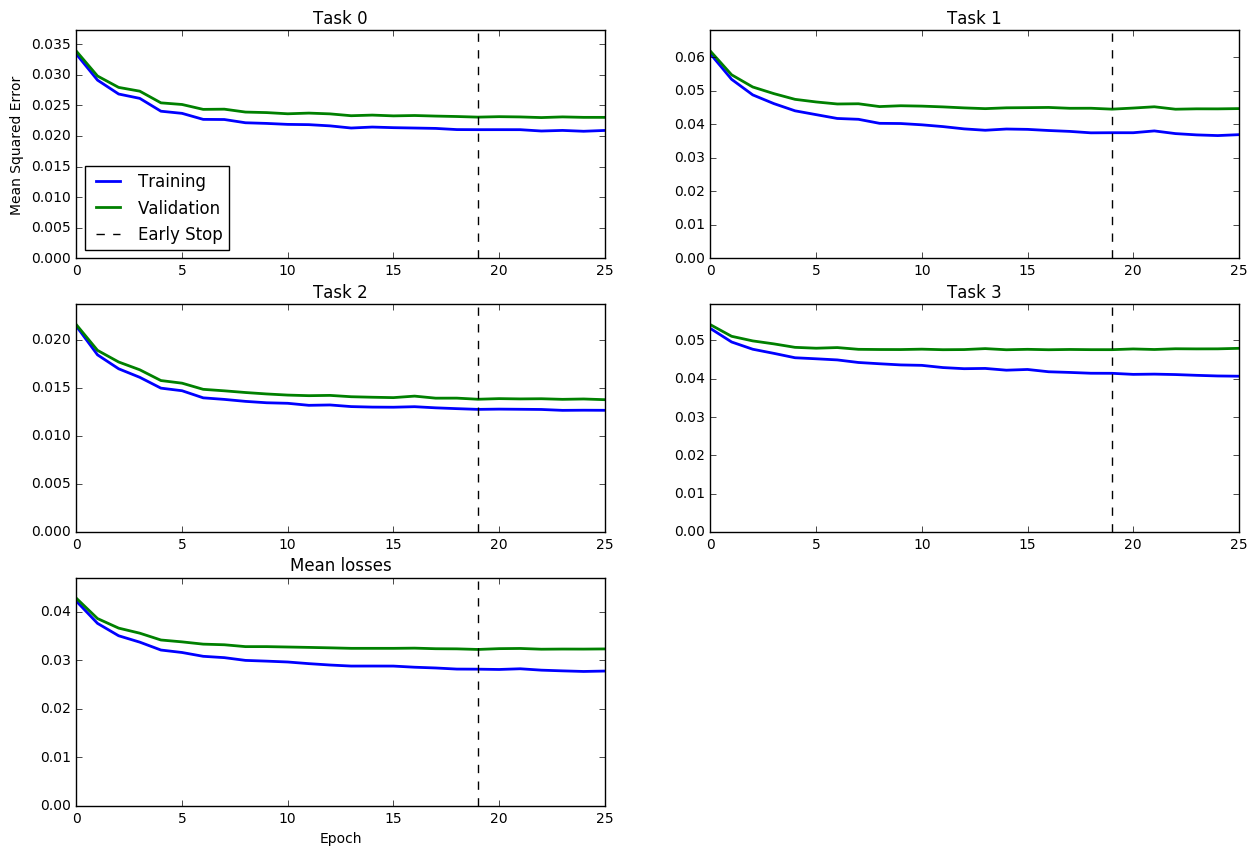

In [21]:
metric = "Mean Squared Error"
print_perf(model, metric)

In [22]:
(sum(np.asarray(y_train)) + sum(np.asarray(y_valid))) / (len(y_train) + len(y_valid))

array([-0.17303934, -0.24127505, -0.12425002, -0.06486262])

In [23]:
sum(np.asarray(y_valid)) / len(y_valid)

array([-0.17319615, -0.24186753, -0.12459584, -0.06514178])